In [2]:
""" reference:
        https://florianwilhelm.info/2017/04/causal_inference_propensity_score/ 
"""

' reference:\n        https://florianwilhelm.info/2017/04/causal_inference_propensity_score/ \n'

In [6]:
from math import exp, log

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.special import expit

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams["figure.figsize"] = 10, 8

np.seterr(divide='ignore', invalid='ignore')
np.random.seed(42)

# Model

In [7]:
def exp_recovery_time(sex, age, severity, medication):
    return exp(2 + 0.5*sex + 0.03*age + 2*severity - 1*medication)

def rvs_recovery_time(sex, age, severity, medication, *args):
    return stats.poisson.rvs(exp_recovery_time(sex, age, severity, medication))

In [8]:
N = 10000 # number of observations, i.e. patients
sexes = np.random.randint(0, 2, size=N) # sex == 1 if male otherwise female
ages_dist = stats.gamma(8, scale=4)
ages = ages_dist.rvs(size=N)
sev_dist = stats.beta(3, 1.5)
severties = sev_dist.rvs(size=N)

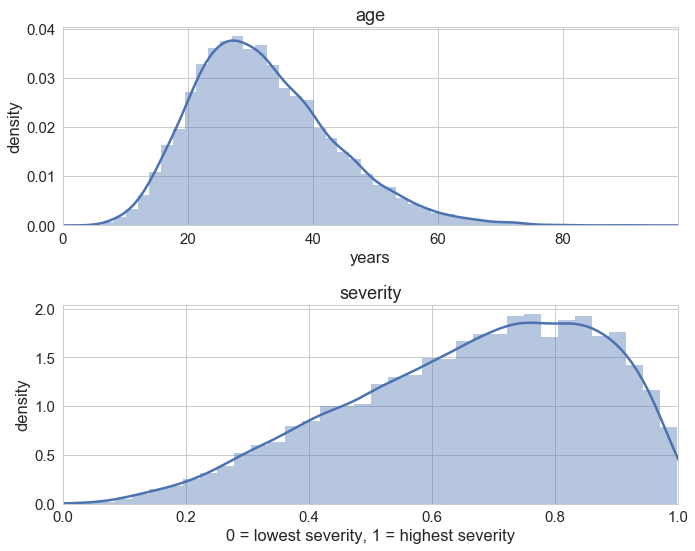

In [10]:
f, (ax1, ax2) = plt.subplots(2)
ax1.set_title('age')
ax1.set_xlabel('years')
ax1.set_ylabel('density')
ax1.set_xlim(0, np.max(ages))
ax2.set_title('severity')
ax2.set_xlabel('0 = lowest severity, 1 = highest severity')
ax2.set_ylabel('density')
ax2.set_xlim(0, 1)
sns.distplot(ages, ax=ax1)
sns.distplot(severties, ax=ax2)
plt.tight_layout();

# Randomized trial

In [11]:
meds = np.random.randint(0, 2, size=N)

In [12]:
const = np.ones(N)
df_rnd = pd.DataFrame(dict(sex=sexes, age=ages, severity=severties, medication=meds, const=const))
features = ['sex', 'age', 'severity', 'medication', 'const']
df_rnd = df_rnd[features] # to enforce column order
df_rnd['recovery'] = df_rnd.apply(lambda x: rvs_recovery_time(*x), axis=1)
df_rnd.head()

,sex,age,severity,medication,const,recovery
0,0,24.518667,0.858950,1,1.0,34
1,1,11.080205,0.905123,0,1.0,97
2,0,37.014895,0.601475,0,1.0,77
3,0,35.657701,0.749840,1,1.0,39
4,0,36.735167,0.385460,1,1.0,18


In [13]:
df_rnd.describe()

,sex,age,severity,medication,const,recovery
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000
mean,0.498700,32.160968,0.666299,0.497400,1.0,76.085700
std,0.500023,11.243333,0.201010,0.500018,0.0,63.304659
min,0.000000,4.508904,0.029818,0.000000,1.0,0.000000
25%,0.000000,24.044093,0.525905,0.000000,1.0,33.000000
50%,0.000000,30.760101,0.693532,0.000000,1.0,57.000000
75%,1.000000,38.922208,0.829290,1.000000,1.0,99.000000
max,1.000000,98.330906,0.999327,1.000000,1.0,805.000000


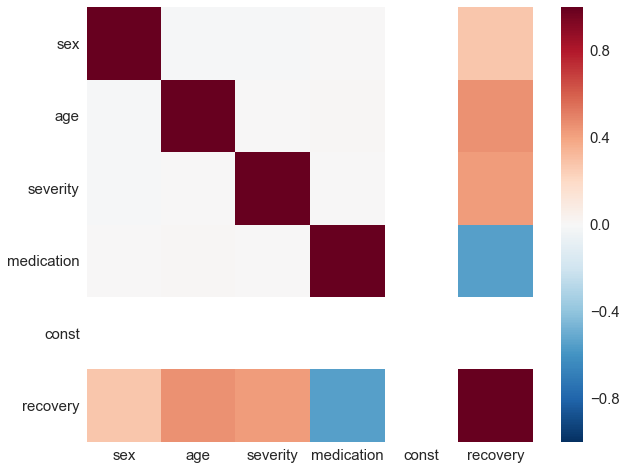

In [14]:
sns.heatmap(df_rnd.corr(), vmin=-1, vmax=1);

In [15]:
glm = sm.GLM(df_rnd['recovery'], df_rnd[features], family=sm.families.Poisson()) # sm.GLM(data.endog, data.exog, ...)
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               recovery   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9995
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34429.
Date:                Sun, 03 Mar 2019   Deviance:                       10080.
Time:                        14:22:18   Pearson chi2:                 1.00e+04
No. Iterations:                     5   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex            0.4994      0.002    211.934      0.000       0.495       0.504
age            0.0301   8.95e-05    335.807      0.000       0.030       0.030
severity       2.0000      0.006    309.610      0.000       1.987       2.013
medication    -1.0024      0.003   -387.721      0.000      -1.007      -0.997
const          1.9990      0.006    326.234      0.000       1.987       2.011
==============================================================================
"""

In [18]:
reg = RandomForestRegressor()
X = df_rnd[features].as_matrix()
y = df_rnd['recovery'].values
reg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [19]:
X_neg = np.copy(X)
X_pos = np.copy(X)

# set the medication column to 0
X_neg[:, df_rnd.columns.get_loc('medication')] = 0

# set the medication column to 1
X_pos[:, df_rnd.columns.get_loc('medication')] = 1

preds_rnd = reg.predict(X_pos) / reg.predict(X_neg)

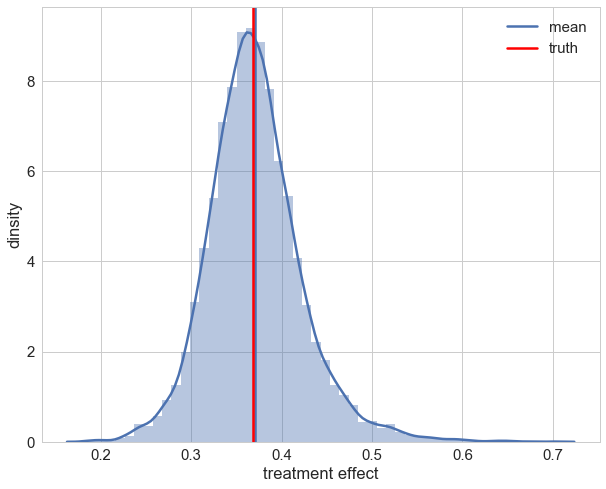

In [23]:
ax = sns.distplot(preds_rnd)
ax.set_xlabel('treatment effect')
ax.set_ylabel('dinsity')
plt.axvline(np.mean(preds_rnd), label='mean')
plt.axvline(np.exp(-1), color='r', label='truth')
plt.legend();

# Non-randomized trial

In [24]:
def get_medication(sex, age, severity, medication, *args):
    return int(1/3*sex + 2/3*severity + 0.15*np.random.randn() > 0.8)

In [25]:
df_obs = df_rnd.copy().drop('recovery', axis=1)
df_obs['medication'] = df_obs.apply(lambda x: get_medication(*x), axis=1)
df_obs['recovery'] = df_obs.apply(lambda x: rvs_recovery_time(*x), axis=1)
df_obs.describe()

,sex,age,severity,medication,const,recovery
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000
mean,0.498700,32.160968,0.666299,0.251900,1.0,85.029100
std,0.500023,11.243333,0.201010,0.434126,0.0,51.400825
min,0.000000,4.508904,0.029818,0.000000,1.0,8.000000
25%,0.000000,24.044093,0.525905,0.000000,1.0,50.000000
50%,0.000000,30.760101,0.693532,0.000000,1.0,73.000000
75%,1.000000,38.922208,0.829290,1.000000,1.0,106.000000
max,1.000000,98.330906,0.999327,1.000000,1.0,624.000000


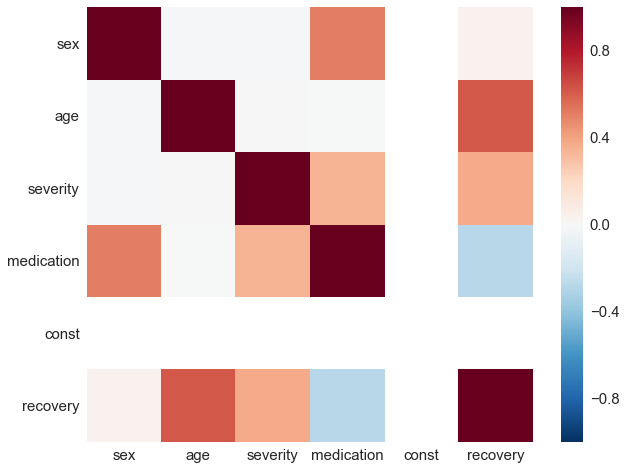

In [26]:
sns.heatmap(df_obs.corr(), vmin=-1, vmax=1);

In [27]:
glm = sm.GLM(df_obs['recovery'], df_obs[features], family=sm.families.Poisson())
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               recovery   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9995
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35645.
Date:                Sun, 03 Mar 2019   Deviance:                       10018.
Time:                        14:48:40   Pearson chi2:                 9.98e+03
No. Iterations:                     5   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex            0.5043      0.002    203.256      0.000       0.499       0.509
age            0.0299   8.58e-05    349.024      0.000       0.030       0.030
severity       1.9996      0.006    313.055      0.000       1.987       2.012
medication    -1.0063      0.003   -302.201      0.000      -1.013      -1.000
const          2.0013      0.006    340.305      0.000       1.990       2.013
==============================================================================
"""

In [28]:
reg = RandomForestRegressor()
X = df_obs[features].as_matrix()
y = df_obs['recovery'].values
reg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [29]:
X_neg = np.copy(X)
X_pos = np.copy(X)

# set the medication column to 0
X_neg[:, df_obs.columns.get_loc('medication')] = 0

# set the medication column to 1
X_pos[:, df_obs.columns.get_loc('medication')] = 1

preds_no_rnd = reg.predict(X_pos) / reg.predict(X_neg)

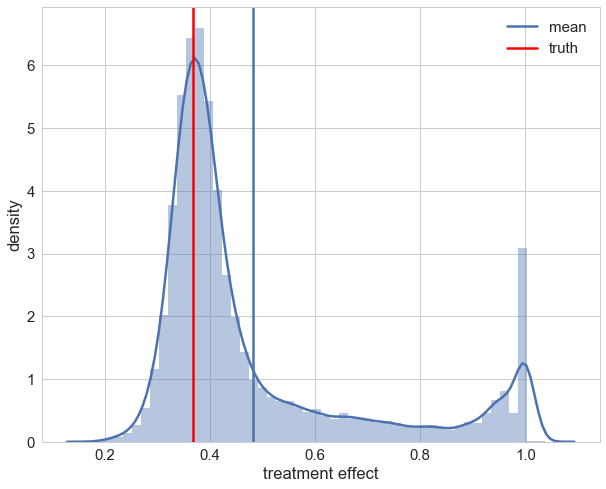

In [30]:
ax = sns.distplot(preds_no_rnd)
ax.set_xlabel('treatment effect')
ax.set_ylabel('density')
plt.axvline(np.mean(preds_no_rnd), label='mean')
plt.axvline(np.exp(-1), color='r', label='truth')
plt.legend();

# Invers Probability Weighting

In [31]:
# classifier to estimate the propensity score
cls = LogisticRegression(random_state=42)
#cls = GaussianNB() # another possible propensity score estimator

# calibration of the classifier
cls = CalibratedClassifierCV(cls)

X = df_obs[features].drop(['medication'], axis=1).as_matrix()
y = df_obs['medication'].values
cls.fit(X, y)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
            cv=3, method='sigmoid')

In [33]:
propensity = pd.DataFrame(cls.predict_proba(X))
propensity.head()

,0,1
0,0.947430,0.052570
1,0.170632,0.829368
2,0.992034,0.007966
3,0.975970,0.024030
4,0.998434,0.001566


### We can see that the propensity scores of our patients in the non-randomized trial vary a lot

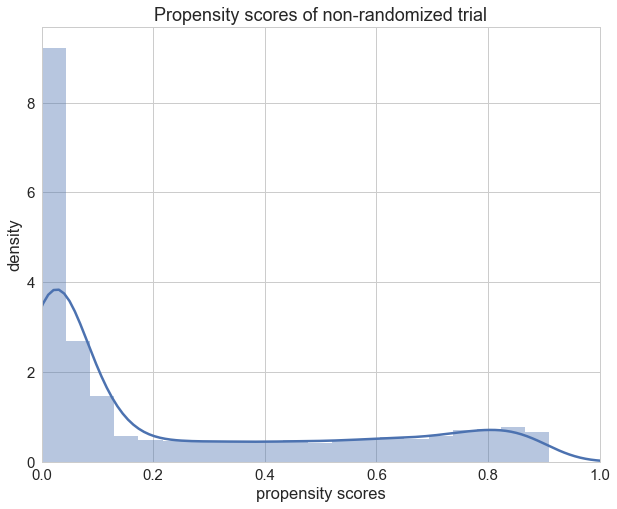

In [34]:
ax = sns.distplot(propensity[1].values)
ax.set_xlim(0, 1)
ax.set_title("Propensity scores of non-randomized trial")
ax.set_xlabel("propensity scores")
ax.set_ylabel("density");

### Whereas, the propensity scores of the randomized trial are around 0.5, which means that the classifier cannot classify well based on the given features

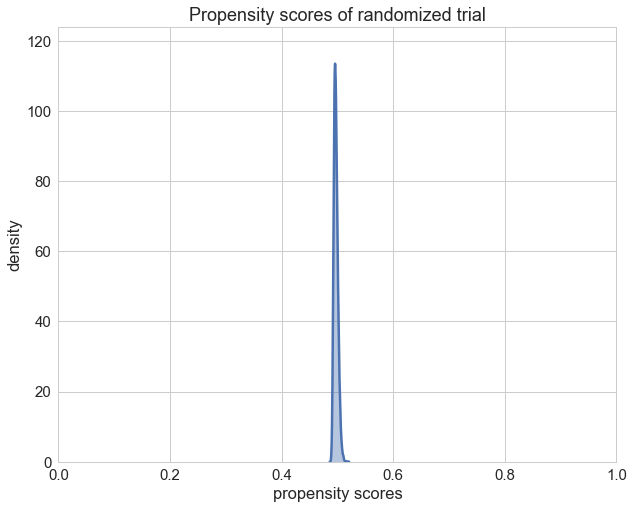

In [36]:
X = df_rnd[features].drop(["medication"], axis=1).as_matrix()
y = df_rnd['medication'].values
cls.fit(X, y)
ax = sns.distplot(cls.predict_proba(X)[:, 1])
ax.set_xlim(0, 1)
ax.set_title("Propensity scores of randomized trial")
ax.set_xlabel("propensity scores")
ax.set_ylabel("density");

In [40]:
# DataFrame's lookup method extracts the column index provided by df_obs['medication'] for each row
df_obs["iptw"] = 1 / propensity.lookup(np.arange(propensity.shape[0]), df_obs["medication"])

In [41]:
df_obs.describe()

,sex,age,severity,medication,const,recovery,iptw
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000
mean,0.498700,32.160968,0.666299,0.251900,1.0,85.029100,1.860499
std,0.500023,11.243333,0.201010,0.434126,0.0,51.400825,4.455724
min,0.000000,4.508904,0.029818,0.000000,1.0,8.000000,1.000105
25%,0.000000,24.044093,0.525905,0.000000,1.0,50.000000,1.016131
50%,0.000000,30.760101,0.693532,0.000000,1.0,73.000000,1.093217
75%,1.000000,38.922208,0.829290,1.000000,1.0,106.000000,1.449351
max,1.000000,98.330906,0.999327,1.000000,1.0,624.000000,184.561863


### The poisson regression benefits from using the IPTWs as weights since the Z-scores of the coefficients increase.

In [42]:
glm = sm.GLM(df_obs["recovery"], df_obs[features], familiy=sm.families.Poisson(), freq_weights=df_obs["iptw"])
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               recovery   No. Observations:                10000
Model:                            GLM   Df Residuals:                    18599
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          669.88
Method:                          IRLS   Log-Likelihood:                -86929.
Date:                Sun, 03 Mar 2019   Deviance:                   1.2460e+07
Time:                        16:00:59   Pearson chi2:                 1.25e+07
No. Iterations:                     3   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex           43.4506      0.387    112.133      0.000      42.691      44.210
age            2.6566      0.017    155.708      0.000       2.623       2.690
severity     152.2987      0.963    158.172      0.000     150.412     154.186
medication   -75.9412      0.385   -197.374      0.000     -76.695     -75.187
const        -98.0068      0.936   -104.653      0.000     -99.842     -96.171
==============================================================================
"""

In [44]:
reg = RandomForestRegressor(random_state=42)
X = df_obs[features].as_matrix()
y = df_obs['recovery'].values
reg.fit(X, y, sample_weight=df_obs['iptw'].values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [45]:
X_neg = np.copy(X)
X_pos = np.copy(X)

# set the medication column to 0
X_neg[:, df_obs.columns.get_loc('medication')] = 0

# set the medication column to 1
X_pos[:, df_obs.columns.get_loc('medication')] = 1

preds_propensity = reg.predict(X_pos) / reg.predict(X_neg)

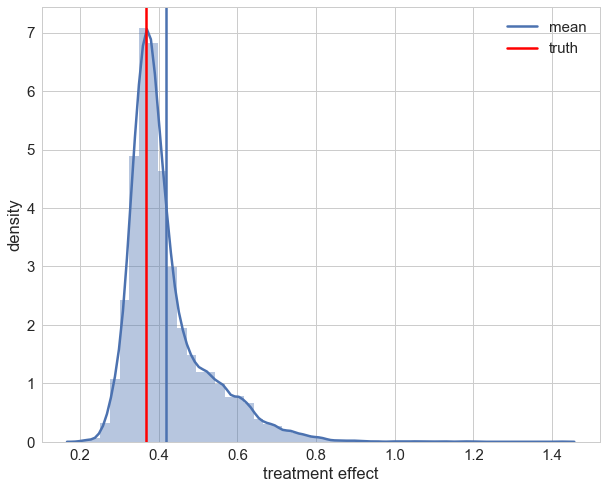

In [46]:
ax = sns.distplot(preds_propensity)
ax.set_xlabel('treatment effect')
ax.set_ylabel('density')
plt.axvline(np.mean(preds_propensity), label='mean')
plt.axvline(np.exp(-1), color='r', label='truth')
plt.legend();

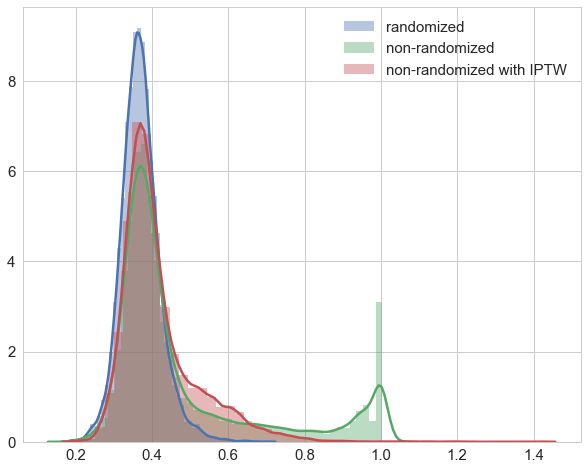

In [47]:
sns.distplot(preds_rnd, label='randomized')
sns.distplot(preds_no_rnd, label='non-randomized')
sns.distplot(preds_propensity, label='non-randomized with IPTW')
ax.set_xlabel('treatment effect')
ax.set_ylabel('density')
plt.legend();

In [48]:
def weighted_corr(m, w=None):
    if w is None:
        w = np.ones(m.shape[0])
    cov = np.cov(m, rowvar=False, aweights=w, ddof=0)
    sigma = np.sqrt(np.diag(cov))
    return cov / np.outer(sigma, sigma)

### When setting all weights to 1

In [49]:
sel_cols = [col for col in df_obs.columns if col != 'iptw']
orig_corr = weighted_corr(df_obs[sel_cols].as_matrix(), w=np.ones(df_obs.shape[0]))
orig_corr = pd.DataFrame(orig_corr, index=sel_cols, columns=sel_cols)
orig_corr

,sex,age,severity,medication,const,recovery
sex,1.000000,-0.013332,-0.012855,0.509914,NaN,0.046250
age,-0.013332,1.000000,0.005086,-0.002818,NaN,0.622472
severity,-0.012855,0.005086,1.000000,0.348317,NaN,0.378225
medication,0.509914,-0.002818,0.348317,1.000000,NaN,-0.276164
const,NaN,NaN,NaN,NaN,NaN,NaN
recovery,0.046250,0.622472,0.378225,-0.276164,NaN,1.000000


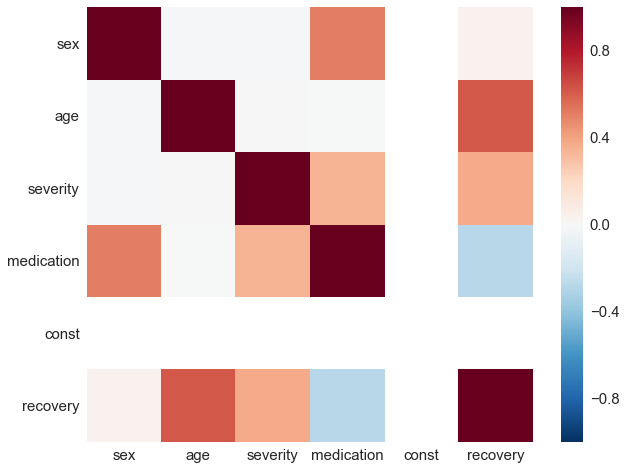

In [50]:
sns.heatmap(orig_corr, vmin=-1, vmax=1);

### When using IPTWs

In [51]:
iptw_corr = weighted_corr(df_obs[sel_cols].as_matrix(), w=df_obs['iptw'].values)
iptw_corr = pd.DataFrame(iptw_corr, index=sel_cols, columns=sel_cols)
iptw_corr

,sex,age,severity,medication,const,recovery
sex,1.000000,-0.001601,-0.154496,0.087948,NaN,0.222515
age,-0.001601,1.000000,-0.028975,0.014248,NaN,0.461467
severity,-0.154496,-0.028975,1.000000,0.103541,NaN,0.369249
medication,0.087948,0.014248,0.103541,1.000000,NaN,-0.531669
const,NaN,NaN,NaN,NaN,NaN,NaN
recovery,0.222515,0.461467,0.369249,-0.531669,NaN,1.000000


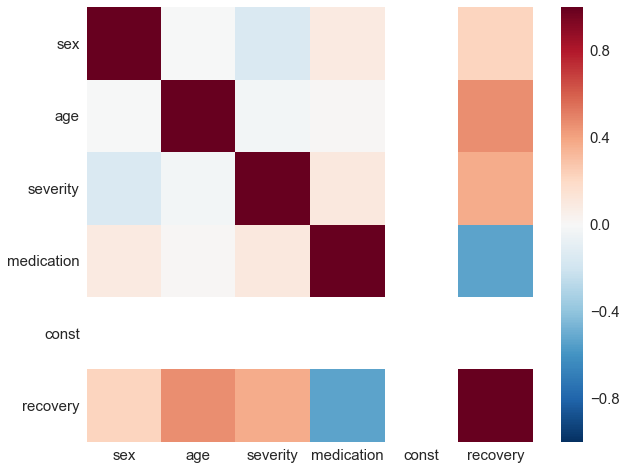

In [52]:
sns.heatmap(iptw_corr, vmin=-1, vmax=1);